In this notebook, we are going to check the mapped satellite data generated using the different atmospheric corrections for the Kamchatka day-of remobilization event.


# Approach

Compare the chlorophyll-a data in the region of the plume and over the whole image for

1. A2015258013500
2. A2015259022000
3. A2015259022000_ang0-578
4. A2015259022000_taua_0-169_0-437
5. A2015260012500

# Initializing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import re
import pyproj as pp
%matplotlib inline

Setting file paths:

In [10]:
fileDir = 'C:/Users/cmitchell/SHARE/satellieFiles/volcano/'
satFiles = ['A2015258013500_mapped.nc','A2015259022000_mapped.nc','A2015259022000_taua_0-169_0-437_mapped.nc',
            'A2015259022000_ang0-578_mapped.nc','A2015260012500_mapped.nc']
keys = ['day258','day259-default','day259-aod','day259-ang','day260']
fileList = dict(zip(keys,satFiles))

# Analysing all files

In the original notebook (**`LabBook-v2`**) I did the histograms and stats on the plume region. Here I want to do it on a slightly larger region, because it's really consistency across the whole region between the day before, day of and day after that I am looking for. So I changed the limits in the piece of code below, so now the `geophys_plume` dataset is actually a bit larger than just the plume. Note, I did run all the histograms and stats with the limits used in the original notebook first (i.e. for just the plume), and compared them with the original notebook numbers and they were comparable.

First, let's create xarray DataSets for the data

In [20]:
geophys = {}
geophys_plume = {}
for key,file in fileList.items():
    #importing data
    geophys[key] = xr.load_dataset(fileDir + file)
    
    #subscening
    lonE = 168
    lonW = 159
    latN = 58.1 #nb I had to adjust this slightly so all the datasets had the same dims
    latS = 54
    
    geophys_plume[key] = geophys[key].sel(lon=slice(lonW,lonE),lat=slice(latN,latS))

### Histograms and statistics


C:\Users\cmitchell\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\cmitchell\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


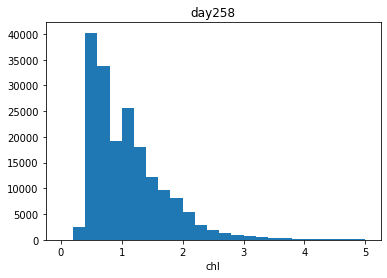

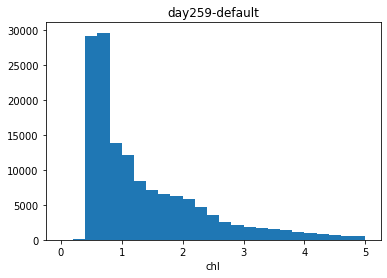

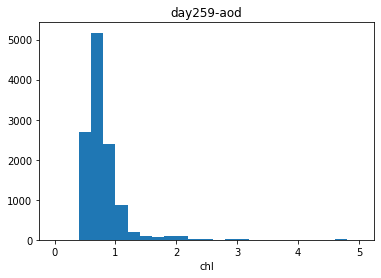

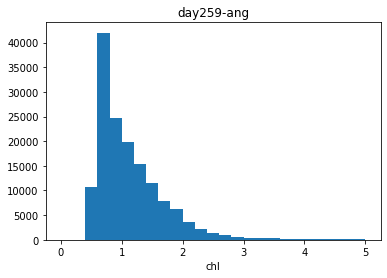

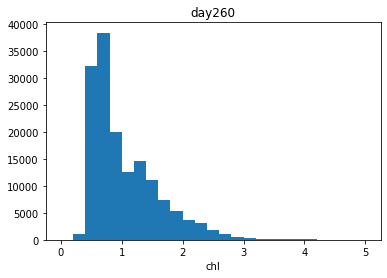

In [30]:
statistics = {}
for key,ds in geophys_plume.items():
    
    plt.figure(figsize=(6,4))
    plt.hist(ds['chlor_a'].data.flatten(),bins=25,range=(0,5));
    plt.title(key)
    plt.xlabel('chl')
    plt.savefig('hist_chl_'+key+'.png',dpi=300)
    
    DATA = ds['chlor_a']

    statistics[key] = [np.nanmin(DATA),np.nanmax(DATA),np.nanmedian(DATA),np.nanmean(DATA),
                np.nanstd(DATA),stats.mstats.gmean(DATA.data.flatten()[~np.isnan(DATA.data.flatten())])]

statistics = pd.DataFrame.from_dict(statistics,orient='index',columns=['min','max','median','mean','stdev','geo mean'])

In [23]:
statistics

,min,max,median,mean,stdev,geo mean
day258,0.270699,188.736755,0.969118,1.152394,1.648389,0.966072
day259-default,0.001000,451.988159,1.029073,2.219923,9.569367,1.203861
day259-aod,0.404208,25.797037,0.730537,1.047891,1.863183,0.795177
day259-ang,0.453208,139.740860,0.981026,1.232604,1.607464,1.047025
day260,0.352070,32.402107,0.846820,1.085948,0.858407,0.933157


### Plots of the plume region

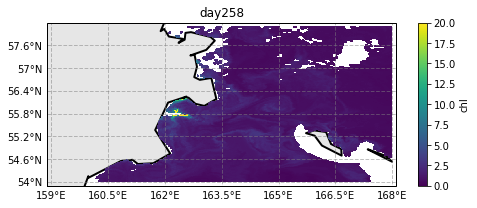

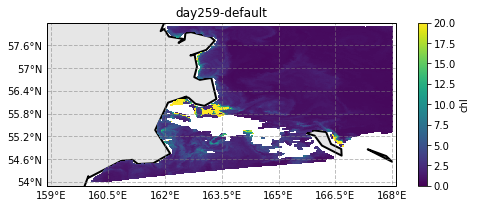

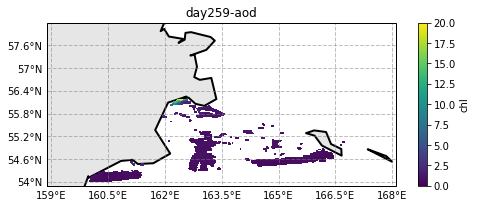

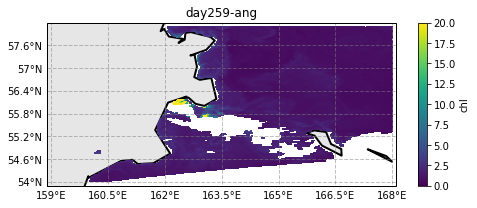

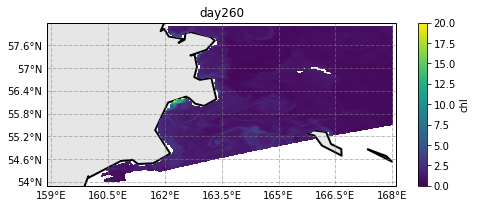

In [31]:
for key,ds in geophys_plume.items():
    plt.figure(figsize=(8,3))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set lat and long limits here
    ax.set_extent([lonW-0.1,lonE+0.1,latS-0.1,latN+0.1])

    #doing the gridlines, haven't figured out how to
    #do the xticks neatly, so for now, I'm keeping the 
    #grey gridlines on the image
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    #adding land
    land = cfeature.GSHHSFeature(
            scale='l',lw=2,
            facecolor=[0.9,0.9,0.9])
    ax.add_feature(land)

    #formatting lats and lons
    x,y = np.meshgrid(ds.lon,ds.lat)
        
    #plotting the satellite data
    plt.pcolormesh(x,y, 
               np.ma.masked_where(np.isnan(ds.chlor_a),ds.chlor_a), 
                 transform=ccrs.PlateCarree(),zorder=2,
                  vmin=0,vmax=20)
    plt.colorbar(label='chl')
    plt.title(key)
    plt.savefig('chl_map_'+key+'.png',dpi=300)

### Differences

What is the difference in the chl product for the different methods?

#### Difference with day 258

First we need to pull out only the day 259 days:

In [25]:
regex = re.compile('day259-')
day259keys = [kk for kk in keys if regex.search(kk)]

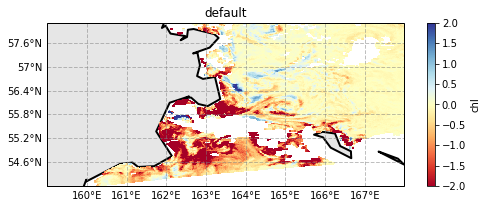

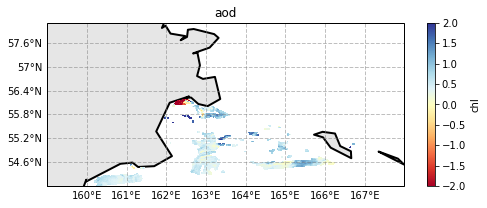

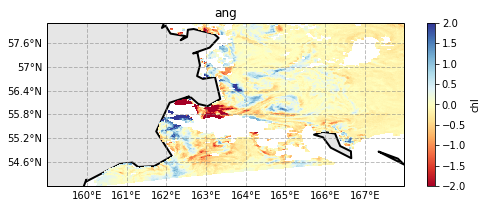

In [32]:
for key in day259keys:
    ds = geophys_plume[key]
    diffs = geophys_plume['day258'].chlor_a.data - ds.chlor_a.data
    
    plt.figure(figsize=(8,3))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set lat and long limits here
    ax.set_extent([lonW,lonE,latS,latN])

    #doing the gridlines, haven't figured out how to
    #do the xticks neatly, so for now, I'm keeping the 
    #grey gridlines on the image
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    #adding land
    land = cfeature.GSHHSFeature(
            scale='l',lw=2,
            facecolor=[0.9,0.9,0.9])
    ax.add_feature(land)

    #formatting lats and lons
    x,y = np.meshgrid(ds.lon,ds.lat)
    
    #plotting the satellite data
    #norm= colors.LogNorm(vmin=1, vmax=20)
    plt.pcolormesh(x,y,  
               np.ma.masked_where(np.isnan(diffs),diffs), 
                 transform=ccrs.PlateCarree(),zorder=2,
                  vmin=-2,vmax=2,cmap='RdYlBu')#norm=norm)
    plt.colorbar(label='chl')
    plt.title(key[7:])
    plt.savefig('chl_diff_map_day258-day259'+key+'.png',dpi=300)

#### Difference with day 260

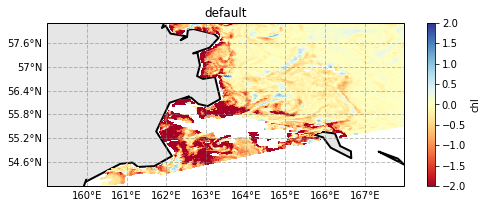

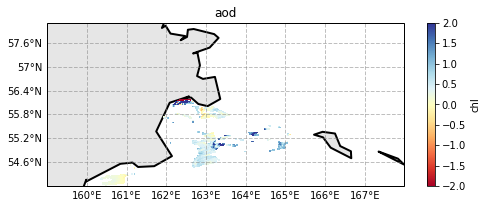

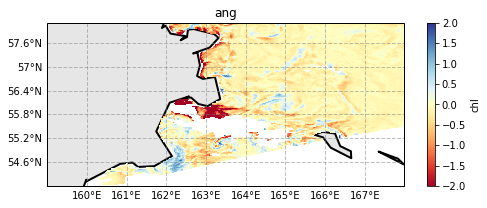

In [33]:
for key in day259keys:
    ds = geophys_plume[key]
    diffs = geophys_plume['day260'].chlor_a.data - ds.chlor_a.data
    
    plt.figure(figsize=(8,3))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set lat and long limits here
    ax.set_extent([lonW,lonE,latS,latN])

    #doing the gridlines, haven't figured out how to
    #do the xticks neatly, so for now, I'm keeping the 
    #grey gridlines on the image
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    #adding land
    land = cfeature.GSHHSFeature(
            scale='l',lw=2,
            facecolor=[0.9,0.9,0.9])
    ax.add_feature(land)

    #formatting lats and lons
    x,y = np.meshgrid(ds.lon,ds.lat)
    
    #plotting the satellite data
    #norm= colors.LogNorm(vmin=1, vmax=20)
    plt.pcolormesh(x,y,  
               np.ma.masked_where(np.isnan(diffs),diffs), 
                 transform=ccrs.PlateCarree(),zorder=2,
                  vmin=-2,vmax=2,cmap='RdYlBu')#norm=norm)
    plt.colorbar(label='chl')
    plt.title(key[7:])
    plt.savefig('chl_diff_map_day260-day259'+key+'.png',dpi=300)

#### Difference between 258 and 260

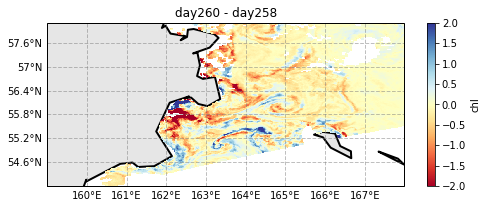

In [34]:
diffs = geophys_plume['day260'].chlor_a.data - geophys_plume['day258'].chlor_a.data

plt.figure(figsize=(8,3))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set lat and long limits here
ax.set_extent([lonW,lonE,latS,latN])

#doing the gridlines, haven't figured out how to
#do the xticks neatly, so for now, I'm keeping the 
#grey gridlines on the image
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#adding land
land = cfeature.GSHHSFeature(
        scale='l',lw=2,
        facecolor=[0.9,0.9,0.9])
ax.add_feature(land)

#formatting lats and lons
x,y = np.meshgrid(geophys_plume['day258'].lon,geophys_plume['day258'].lat)

#plotting the satellite data
#norm= colors.LogNorm(vmin=1, vmax=20)
plt.pcolormesh(x,y,  
           np.ma.masked_where(np.isnan(diffs),diffs), 
             transform=ccrs.PlateCarree(),zorder=2,
              vmin=-2,vmax=2,cmap='RdYlBu')#norm=norm)
plt.colorbar(label='chl')
plt.title('day260 - day258');
plt.savefig('chl_diff_map_day260-day258.png',dpi=300)